In [ ]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, ConfusionMatrixDisplay
import pandas as pd
import shutil

In [3]:
size = 299
BATCH_SIZE = 32
class_names = ["0", "1"]

#### Load Dataset

In [4]:
url = "https://storage.googleapis.com/proj-slides/slides.zip"
!curl -O $url
!unzip -q /content/slides.zip -d /content/
!rm -r /content/__MACOSX
!rm /content/slides.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 22.2G  100 22.2G    0     0  22.5M      0  0:16:50  0:16:50 --:--:-- 23.3M


In [5]:
slides_path = "/content/slides/tif/"
masks_path = "/content/slides/mask/"
slide_files = sorted([x for x in os.listdir(slides_path) if x.endswith(".tif")])
mask_files = sorted([x for x in os.listdir(masks_path) if x.endswith(".tif")])

In [6]:
# Helper functions 

def slide_mask_match(slide_path, mask_path):
  slide = open_slide(slide_path)
  mask = open_slide(mask_path)
  # since usually sildes have more dims than masks
  dims = min(len(slide.level_dimensions), len(mask.level_dimensions))
  for i in range(dims):
    assert mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert mask.level_dimensions[i][1] == slide.level_dimensions[i][1]


def downsampling_check(slide_path):
  slide = open_slide(slide_path)
  for i in range(len(slide.level_dimensions)):
    width, height = slide.level_dimensions[i]
    assert width * slide.level_downsamples[i] == slide.level_dimensions[0][0]
    assert height * slide.level_downsamples[i] == slide.level_dimensions[0][1]


In [7]:
# check slides consistency 

for slide_file, mask_file in zip(slide_files, mask_files):
  slide_mask_match(os.path.join(slides_path, slide_file), 
                   os.path.join(masks_path, mask_file))
  downsampling_check(os.path.join(slides_path, slide_file))

print("All slices are good.")

All slices are good.


#### Generate Dataset

In [8]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im


def tissue_above_threshold(image, intensity=0.8, threshold=20):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    tissue_pixels = list(zip(indices[0], indices[1]))
    percent_tissue = len(tissue_pixels)/float(image.shape[0] * image.shape[0])*100
    return percent_tissue >= threshold


def save_image(image, out_path, label, name, counter):
    label = str(label)
    out_file = os.path.join(out_path, label, 
                            name + "_" + str(counter).zfill(5)+".jpg")
    image = Image.fromarray(image)
    image.save(out_file)


In [9]:
def get_center_coordinates(x, y, size=299):
  # Size is the size of the patch where we try to get the center point for
  # x,y are the top left point coordinates wrt downsampled image
  # it returns the coordinates wrt downsampled image 
  x = x + size//2
  y = y + size//2
  return x, y


def convert_scale(x, y, downsampling_factor_old, downsampling_factor_new):
  # This function is to get the same point from a level to another level
  x = int(x * downsampling_factor_old / downsampling_factor_new)
  y = int(y * downsampling_factor_old / downsampling_factor_new)
  return x, y


def get_top_left_coordinates(x, y, size=299):
  # Size is the size of the patch where we try to get the top left point for
  # x,y are the center point coordinates wrt downsampled image
  # it returns the coordinates wrt downsampled image 
  x = x - size//2
  y = y - size//2
  return x, y


In [10]:
def generate_patches(slide_path, mask_path, out_path_l1, out_path_l2):
  # Using 2 levels of resolution (2 and 3) to generate the dataset
  level_1 = 2
  level_2 = 3
  name = slide_path.split("/")[-1].split(".")[0]
  slide = open_slide(slide_path)
  mask = open_slide(mask_path)
  width_l1, height_l1 = slide.level_dimensions[level_1]
  downsampling_l1 = int(slide.level_downsamples[level_1])
  width_l2, height_l2 = slide.level_dimensions[level_2]
  downsampling_l2 = int(slide.level_downsamples[level_2])
  size = 299
  step = 299
  counter, pos_counter, neg_counter = 0, 0, 0 

  for x in range(0, width_l1, step):
    for y in range(0, height_l1, step):
      image_l1 = read_slide(slide, x= x * downsampling_l1, y= y * downsampling_l1, 
                         level=level_1, width=size, height=size)
      
      if tissue_above_threshold(image_l1):
        mask_l1 = read_slide(mask, x= x * downsampling_l1, y= y * downsampling_l1, 
                         level=level_1, width=size, height=size)[:,:,0]
        x_center, y_center = get_center_coordinates(x, y, size)
        x_center, y_center = convert_scale(x_center, y_center, downsampling_l1, downsampling_l2)
        x_new, y_new = get_top_left_coordinates(x_center, y_center, size)
        image_l2 = read_slide(slide, x= x_new * downsampling_l2, y= y_new * downsampling_l2, 
                         level=level_2, width=size, height=size)
        
        label = 1 if mask_l1.sum() > 0 else 0 
        save_image(image_l1, out_path_l1, label, name, counter)
        save_image(image_l2, out_path_l2, label, name, counter)

        if label == 0:
          neg_counter += 1
        else: 
          pos_counter += 1
        counter += 1 
    
  print("Found %d images in %s with %d positive samples and %d negative samples." 
          %(counter, name, pos_counter, neg_counter))
    


In [11]:
def generate_pos_patches(slide_path, mask_path, out_path_l1, out_path_l2):
  # Using 2 levels of resolution (2 and 3) to generate more positive images
  level_1 = 2
  level_2 = 3
  name = slide_path.split("/")[-1].split(".")[0]
  slide = open_slide(slide_path)
  mask = open_slide(mask_path)
  width_l1, height_l1 = slide.level_dimensions[level_1]
  downsampling_l1 = int(slide.level_downsamples[level_1])
  width_l2, height_l2 = slide.level_dimensions[level_2]
  downsampling_l2 = int(slide.level_downsamples[level_2])
  size = 299
  step = 130
  neg_counter = 0
  counter = 3000

  for x in range(0, width_l1, step):
    for y in range(0, height_l1, step):
      image_l1 = read_slide(slide, x= x * downsampling_l1, y= y * downsampling_l1, 
                         level=level_1, width=size, height=size)
      
      if tissue_above_threshold(image_l1):
        mask_l1 = read_slide(mask, x= x * downsampling_l1, y= y * downsampling_l1, 
                         level=level_1, width=size, height=size)[:,:,0]
        if mask_l1.sum() > 0:
          x_center, y_center = get_center_coordinates(x, y, size)
          x_center, y_center = convert_scale(x_center, y_center, downsampling_l1, downsampling_l2)
          x_new, y_new = get_top_left_coordinates(x_center, y_center, size)
          image_l2 = read_slide(slide, x= x_new * downsampling_l2, y= y_new * downsampling_l2, 
                         level=level_2, width=size, height=size)
        
          label = 1 
          save_image(image_l1, out_path_l1, label, name, counter)
          save_image(image_l2, out_path_l2, label, name, counter)

          neg_counter += 1
          counter += 1
    
  print("Found %d positive samples in %s." %(neg_counter, name))
  return neg_counter
    


In [ ]:
# create folders for the dataset 
!mkdir /content/data/

!mkdir /content/data/l1/
!mkdir /content/data/l1/train/
!mkdir /content/data/l1/train/0/
!mkdir /content/data/l1/train/1/
!mkdir /content/data/l1/val/
!mkdir /content/data/l1/val/0/
!mkdir /content/data/l1/val/1/
!mkdir /content/data/l1/test/
!mkdir /content/data/l1/test/0/
!mkdir /content/data/l1/test/1/

!mkdir /content/data/l2/
!mkdir /content/data/l2/train/
!mkdir /content/data/l2/train/0/
!mkdir /content/data/l2/train/1/
!mkdir /content/data/l2/val/
!mkdir /content/data/l2/val/0/
!mkdir /content/data/l2/val/1/
!mkdir /content/data/l2/test/
!mkdir /content/data/l2/test/0/
!mkdir /content/data/l2/test/1/

In [ ]:
#!rm -r /content/data/

In [12]:
train_path_l1 = "/content/data/l1/train/"
val_path_l1 = "/content/data/l1/val/"
test_path_l1 = "/content/data/l1/test/"
train_path_l2 = "/content/data/l2/train/"
val_path_l2 = "/content/data/l2/val/"
test_path_l2 = "/content/data/l2/test/"

# split data into dev and test 
slides_dev, slides_test, masks_dev, masks_test = train_test_split(
    slide_files, mask_files, test_size=0.2, random_state=42)

# split dev data into train and val 
slides_train, slides_val, masks_train, masks_val = train_test_split(
    slides_dev, masks_dev, test_size=0.2, random_state=42)

print("Using %d slides for training, %d slides for validation, and %d slides for testing." 
          %(len(slides_train), len(slides_val), len(slides_test)))

Using 12 slides for training, 4 slides for validation, and 4 slides for testing.


In [ ]:
# Generate patches and save in the proper directory 

print("train dataset")
for slide_file, mask_file in zip(slides_train, masks_train):
  slide_path = os.path.join(slides_path, slide_file)
  mask_path = os.path.join(masks_path, mask_file)
  out_path_l1 = train_path_l1
  out_path_l2 = train_path_l2
  generate_patches(slide_path, mask_path, out_path_l1, out_path_l2)

print("-------------------------")
print("validation dataset")
for slide_file, mask_file in zip(slides_val, masks_val):
  slide_path = os.path.join(slides_path, slide_file)
  mask_path = os.path.join(masks_path, mask_file)
  out_path_l1 = val_path_l1
  out_path_l2 = val_path_l2
  generate_patches(slide_path, mask_path, out_path_l1, out_path_l2)

print("-------------------------")
print("test dataset")
for slide_file, mask_file in zip(slides_test, masks_test):
  slide_path = os.path.join(slides_path, slide_file)
  mask_path = os.path.join(masks_path, mask_file)
  out_path_l1 = test_path_l1
  out_path_l2 = test_path_l2
  generate_patches(slide_path, mask_path, out_path_l1, out_path_l2)


train dataset
Found 1207 images in tumor_064 with 148 positive samples and 1059 negative samples.
Found 2756 images in tumor_078 with 1039 positive samples and 1717 negative samples.
Found 1102 images in tumor_059 with 2 positive samples and 1100 negative samples.
Found 1688 images in tumor_110 with 925 positive samples and 763 negative samples.
Found 855 images in tumor_075 with 95 positive samples and 760 negative samples.
Found 877 images in tumor_031 with 193 positive samples and 684 negative samples.
Found 1901 images in tumor_101 with 218 positive samples and 1683 negative samples.
Found 1380 images in tumor_012 with 5 positive samples and 1375 negative samples.
Found 954 images in tumor_019 with 7 positive samples and 947 negative samples.
Found 1190 images in tumor_035 with 3 positive samples and 1187 negative samples.
Found 1212 images in tumor_016 with 161 positive samples and 1051 negative samples.
Found 1282 images in tumor_081 with 3 positive samples and 1279 negative samp

In [ ]:
assert len(os.listdir(os.path.join(train_path_l1, "0"))) == len(
                      os.listdir(os.path.join(train_path_l2, "0")))
assert len(os.listdir(os.path.join(train_path_l1, "1"))) == len(
                      os.listdir(os.path.join(train_path_l2, "1")))
assert len(os.listdir(os.path.join(val_path_l1, "0"))) == len(
                      os.listdir(os.path.join(val_path_l2, "0")))
assert len(os.listdir(os.path.join(val_path_l1, "1"))) == len(
                      os.listdir(os.path.join(val_path_l2, "1")))
assert len(os.listdir(os.path.join(test_path_l1, "0"))) == len(
                      os.listdir(os.path.join(test_path_l2, "0")))
assert len(os.listdir(os.path.join(test_path_l1, "1"))) == len(
                      os.listdir(os.path.join(test_path_l2, "1")))

In [ ]:
neg_image_count = len(os.listdir(os.path.join(train_path_l1, "0")))
pos_image_count = len(os.listdir(os.path.join(train_path_l2, "1")))
balance_goal_count = neg_image_count - pos_image_count
print("Negative images count: ", neg_image_count)
print("Positive images count: ", pos_image_count)
print("Needed increase to have a balanced dataset: ", balance_goal_count)

all_pos = pd.Series([x.split(".")[0][:-6] for x in os.listdir(os.path.join(train_path_l2, "1"))])
weights = all_pos.value_counts()
# Weights is used to prioritize slides with more cancerous cells to get images from
weights = weights.to_dict()
weights

Negative images count:  13605
Positive images count:  2799
Needed increase to have a balanced dataset:  10806


{'tumor_078': 1039,
 'tumor_110': 925,
 'tumor_101': 218,
 'tumor_031': 193,
 'tumor_016': 161,
 'tumor_064': 148,
 'tumor_075': 95,
 'tumor_019': 7,
 'tumor_012': 5,
 'tumor_035': 3,
 'tumor_081': 3,
 'tumor_059': 2}

In [ ]:
for name in weights.keys():
  slide_path = os.path.join(slides_path, name+".tif")
  mask_path = os.path.join(masks_path, name+"_mask.tif")
  out_path_l1 = train_path_l1
  out_path_l2 = train_path_l2
  added_count = generate_pos_patches(slide_path, mask_path, out_path_l1, out_path_l2)
  pos_image_count = pos_image_count + added_count
  if pos_image_count >= neg_image_count:
    break 

Found 5479 positive samples in tumor_078.
Found 4866 positive samples in tumor_110.
Found 1192 positive samples in tumor_101.


In [ ]:
assert len(os.listdir(os.path.join(train_path_l1, "0"))) == len(
           os.listdir(os.path.join(train_path_l2, "0")))
assert len(os.listdir(os.path.join(train_path_l1, "1"))) == len(
            os.listdir(os.path.join(train_path_l2, "1")))

print("Number of negative samples: ", len(os.listdir(os.path.join(train_path_l1, "0"))))
print("Number of positive samples: ", len(os.listdir(os.path.join(train_path_l1, "1"))))
print("Training data is balanced")

Number of negative samples:  13605
Number of positive samples:  14336
Training data is balanced


In [ ]:
!zip -r /content/data.zip /content/data

In [20]:
data_url = "https://storage.googleapis.com/proj-slides/data.zip"
!curl -O $data_url
!unzip -q /content/data.zip 
!rm /content/data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2260M  100 2260M    0     0  20.5M      0  0:01:50  0:01:50 --:--:-- 20.6M


In [24]:
# Generate datasets 
size = 299

# train df 
files = ["0/"+x for x in os.listdir(os.path.join(train_path_l1, "0"))]
df1 = pd.DataFrame(files, columns=['filename'])
df1["class"] = ["0"]*len(df1)
files = ["1/"+x for x in os.listdir(os.path.join(train_path_l1, "1"))]
df2 = pd.DataFrame(files, columns=['filename'])
df2["class"] = ["1"]*len(df2)
train_df = pd.concat([df1, df2], ignore_index=True)

# val df 
files = ["0/"+x for x in os.listdir(os.path.join(val_path_l1, "0"))]
df1 = pd.DataFrame(files, columns=['filename'])
df1["class"] = ["0"]*len(df1)
files = ["1/"+x for x in os.listdir(os.path.join(val_path_l1, "1"))]
df2 = pd.DataFrame(files, columns=['filename'])
df2["class"] = ["1"]*len(df2)
val_df = pd.concat([df1, df2], ignore_index=True)

# test df 
files = ["0/"+x for x in os.listdir(os.path.join(test_path_l1, "0"))]
df1 = pd.DataFrame(files, columns=['filename'])
df1["class"] = ["0"]*len(df1)
files = ["1/"+x for x in os.listdir(os.path.join(test_path_l1, "1"))]
df2 = pd.DataFrame(files, columns=['filename'])
df2["class"] = ["1"]*len(df2)
test_df = pd.concat([df1, df2], ignore_index=True)

# use data augmentation on training 
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale=1./255, 
      #rotation_range = 90,
      #width_shift_range = 0.2,
      #height_shift_range = 0.2,
      horizontal_flip = True, 
      vertical_flip = True,
      #zoom_range = 0.2,
    )

gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

print("Trainig generators (zoon levels 2 and 3)")
train_gen_l1 = train_gen.flow_from_dataframe(train_df, directory = train_path_l1, 
                                      x_col = 'filename', y_col='class',
                                      target_size = (size, size),
                                      classes = class_names, 
                                      class_mode = "binary",
                                      batch_size = BATCH_SIZE, seed = 123,
                                      shuffle = True)

train_gen_l2 = train_gen.flow_from_dataframe(train_df, directory = train_path_l2, 
                                      x_col = 'filename', y_col='class',
                                      target_size = (size, size),
                                      classes = class_names, 
                                      class_mode = "binary",
                                      batch_size = BATCH_SIZE, seed = 123,
                                      shuffle = True)
  

print("Validation generators (zoon levels 2 and 3)")
val_gen_l1 = gen.flow_from_dataframe(val_df, directory = val_path_l1, 
                                      x_col = 'filename', y_col='class',
                                      target_size = (size, size),
                                      classes = class_names, 
                                      class_mode = "binary",
                                      batch_size = BATCH_SIZE, seed = 123,
                                      shuffle = True)

val_gen_l2 = gen.flow_from_dataframe(val_df, directory = val_path_l2, 
                                      x_col = 'filename', y_col='class',
                                      target_size = (size, size),
                                      classes = class_names, 
                                      class_mode = "binary",
                                      batch_size = BATCH_SIZE, seed = 123,
                                      shuffle = True)
  

print("Test generators (zoon levels 2 and 3)")
test_gen_l1 = gen.flow_from_dataframe(test_df, directory = test_path_l1, 
                                      x_col = 'filename', y_col='class',
                                      target_size = (size, size),
                                      classes = class_names, 
                                      class_mode = "binary",
                                      batch_size = BATCH_SIZE, seed = 123,
                                      shuffle = True)

test_gen_l2 = gen.flow_from_dataframe(test_df, directory = test_path_l2, 
                                      x_col = 'filename', y_col='class',
                                      target_size = (size, size),
                                      classes = class_names, 
                                      class_mode = "binary",
                                      batch_size = BATCH_SIZE, seed = 123,
                                      shuffle = True)


Trainig generators (zoon levels 2 and 3)
Found 27941 validated image filenames belonging to 2 classes.
Found 27941 validated image filenames belonging to 2 classes.
Validation generators (zoon levels 2 and 3)
Found 5685 validated image filenames belonging to 2 classes.
Found 5685 validated image filenames belonging to 2 classes.
Test generators (zoon levels 2 and 3)
Found 4871 validated image filenames belonging to 2 classes.
Found 4871 validated image filenames belonging to 2 classes.


In [25]:
# custom generator to have two images per instance  

class CustomDataGenerator(tf.keras.utils.Sequence):

    def __init__(self, gen_l1, gen_l2, batch_size):
        self.gen_l1 = gen_l1 
        self.gen_l2 = gen_l2
        self.batch_size = batch_size

    def __len__(self):
        return len(self.gen_l1)

    def __getitem__(self, idx):
        X_l1, y = next(self.gen_l1)
        X_l2, y = next(self.gen_l2)
        return (X_l1, X_l2), y 


In [26]:
train_ds = CustomDataGenerator(train_gen_l1, train_gen_l2, BATCH_SIZE)
val_ds = CustomDataGenerator(val_gen_l1, val_gen_l2, BATCH_SIZE)
test_ds = CustomDataGenerator(test_gen_l1, test_gen_l2, BATCH_SIZE)

In [27]:
# check random point for size 
(a,b), c = train_ds[489]
print(a.shape)
print(b.shape)
print(c.shape)

(32, 299, 299, 3)
(32, 299, 299, 3)
(32,)


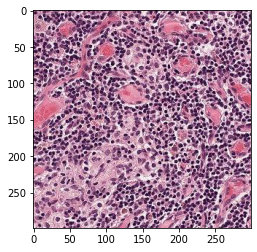

In [28]:
# check that the two generators are not messing up the images 
plt.imshow(a[9,:,:,:])

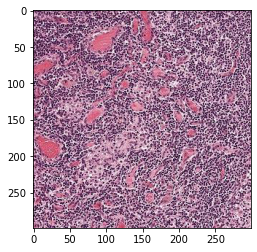

In [29]:
plt.imshow(b[9,:,:,:])
# It corresponds to the previously shown one. 
# The two levels are so differnt but if we zoomed in to the center, 
# it's the same slide.

#### Modeling 

In [30]:
base_model_l1 = tf.keras.applications.ResNet50V2(input_shape=(size, size, 3),
                                               include_top=False,
                                               weights='imagenet') 
                                               
base_model_l2 = tf.keras.applications.ResNet50V2(input_shape=(size, size, 3),
                                               include_top=False,
                                               weights='imagenet') 

base_model_l1.trainable = False
base_model_l2.trainable = False

base_model_l1._name = base_model_l1.name + str("_l1")
base_model_l2._name = base_model_l2.name + str("_l2")


img_shape = (size, size, 3)

# define model
inputs = [tf.keras.Input(shape=img_shape), tf.keras.Input(shape=img_shape)]

x_l1 = base_model_l1(inputs[0], training=False)
x_l2 = base_model_l2(inputs[1], training=False)
x_l1 = tf.keras.layers.GlobalAveragePooling2D()(x_l1)
x_l2 = tf.keras.layers.GlobalAveragePooling2D()(x_l2)
x_l1 = tf.keras.layers.Dense(128, activation="relu")(x_l1)
x_l2 = tf.keras.layers.Dense(128, activation="relu")(x_l2)
x = tf.keras.layers.concatenate([x_l1, x_l2])
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs)


94668760/94668760 [==============================] - 5s 0us/step


In [31]:
metrics = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001) , 
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=metrics)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50v2_l1 (Functional)     (None, 10, 10, 2048  23564800    ['input_3[0][0]']                
                                )                                                             

In [33]:
history = model.fit(train_ds, validation_data=val_ds, epochs=15)

Epoch 1/15
874/874 [==============================] - 382s 415ms/step - loss: 0.1450 - tp: 13414.0000 - fp: 766.0000 - tn: 12830.0000 - fn: 931.0000 - accuracy: 0.9393 - precision: 0.9460 - recall: 0.9351 - auc: 0.9866 - prc: 0.9884 - val_loss: 0.1662 - val_tp: 81.0000 - val_fp: 224.0000 - val_tn: 5299.0000 - val_fn: 81.0000 - val_accuracy: 0.9464 - val_precision: 0.2656 - val_recall: 0.5000 - val_auc: 0.8628 - val_prc: 0.2884
Epoch 2/15
874/874 [==============================] - 343s 392ms/step - loss: 0.0972 - tp: 13719.0000 - fp: 473.0000 - tn: 13145.0000 - fn: 604.0000 - accuracy: 0.9615 - precision: 0.9667 - recall: 0.9578 - auc: 0.9937 - prc: 0.9944 - val_loss: 0.1399 - val_tp: 70.0000 - val_fp: 168.0000 - val_tn: 5353.0000 - val_fn: 94.0000 - val_accuracy: 0.9539 - val_precision: 0.2941 - val_recall: 0.4268 - val_auc: 0.8720 - val_prc: 0.2824
Epoch 3/15
874/874 [==============================] - 342s 391ms/step - loss: 0.0835 - tp: 13819.0000 - fp: 412.0000 - tn: 13185.0000 - fn

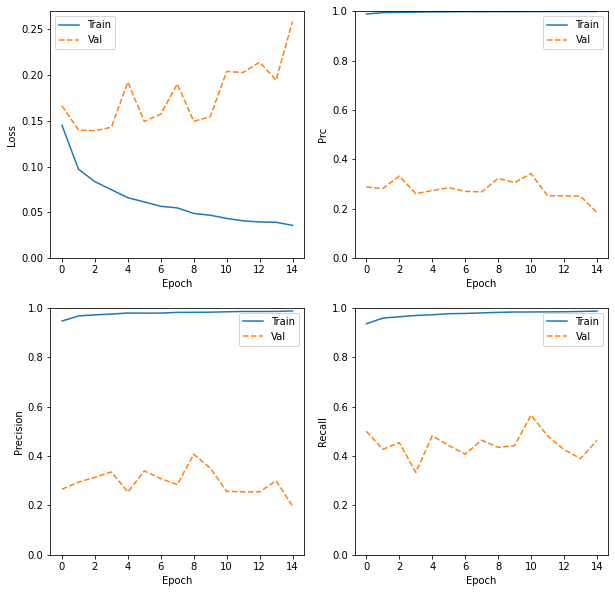

In [36]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  plt.figure(figsize=(10, 10))
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
            linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(history)

In [ ]:
model.save('initial_model', 'initial_model')

In [ ]:
!zip -r /content/initial_model.zip /content/initial_model 

In [ ]:
model = tf.keras.models.load_model('initial_model')

In [37]:
# Fine-tuning 

base_model_l1.trainable = True
base_model_l2.trainable = True

print("Number of layers in the first base model: ", len(base_model_l1.layers))
print("Number of layers in the second base model: ", len(base_model_l2.layers))

# Fine-tune from this layer onwards
fine_tune_at = 140

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model_l1.layers[:fine_tune_at]:
  layer.trainable = False

for layer in base_model_l2.layers[:fine_tune_at]:
  layer.trainable = False


Number of layers in the first base model:  190
Number of layers in the second base model:  190


In [38]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=metrics)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50v2_l1 (Functional)     (None, 10, 10, 2048  23564800    ['input_3[0][0]']                
                                )                                                             

In [39]:
history_fine = model.fit(train_ds, validation_data=val_ds, epochs=30, 
                          initial_epoch=history.epoch[-1])

Epoch 15/30
874/874 [==============================] - 479s 536ms/step - loss: 0.1220 - tp: 13807.0000 - fp: 713.0000 - tn: 18415.0000 - fn: 691.0000 - accuracy: 0.9582 - precision: 0.9509 - recall: 0.9523 - auc: 0.9881 - prc: 0.9857 - val_loss: 0.1719 - val_tp: 105.0000 - val_fp: 219.0000 - val_tn: 5305.0000 - val_fn: 56.0000 - val_accuracy: 0.9516 - val_precision: 0.3241 - val_recall: 0.6522 - val_auc: 0.8637 - val_prc: 0.4682
Epoch 16/30
874/874 [==============================] - 464s 531ms/step - loss: 0.0446 - tp: 14088.0000 - fp: 180.0000 - tn: 13433.0000 - fn: 240.0000 - accuracy: 0.9850 - precision: 0.9874 - recall: 0.9832 - auc: 0.9980 - prc: 0.9982 - val_loss: 0.1445 - val_tp: 26.0000 - val_fp: 10.0000 - val_tn: 5506.0000 - val_fn: 143.0000 - val_accuracy: 0.9731 - val_precision: 0.7222 - val_recall: 0.1538 - val_auc: 0.7634 - val_prc: 0.3476
Epoch 17/30
874/874 [==============================] - 465s 531ms/step - loss: 0.0352 - tp: 14175.0000 - fp: 148.0000 - tn: 13455.0000 

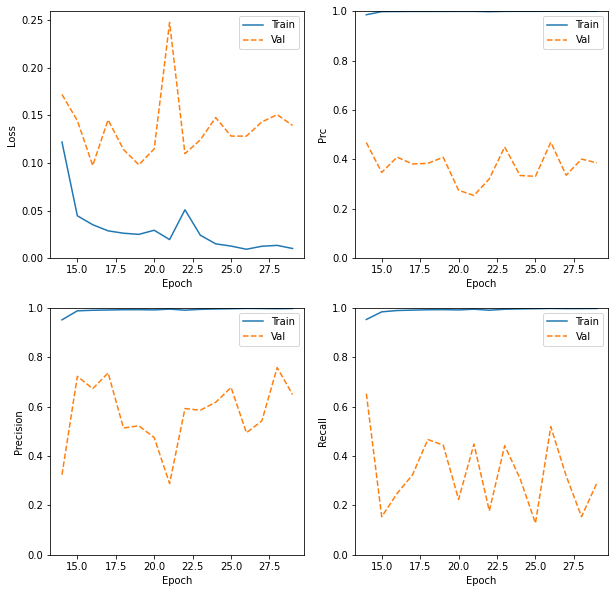

In [41]:
plot_metrics(history_fine)

In [42]:
model.save('final_model', 'final_model')

In [ ]:
!zip -r /content/final_model.zip /content/final_model 

#### Evaluation 

In [ ]:
model_url = "https://storage.googleapis.com/proj-slides/final_model.zip"
!curl -O $model_url
!unzip -q /content/final_model.zip 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  416M  100  416M    0     0   115M      0  0:00:03  0:00:03 --:--:--  115M


In [ ]:
model = tf.keras.models.load_model('final_model')

In [44]:
metrics

In [45]:
results = model.evaluate(test_ds, verbose=0)

for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
print()


loss :  0.07229139655828476
tp :  100.0
fp :  48.0
tn :  4671.0
fn :  52.0
accuracy :  0.9794703125953674
precision :  0.6756756901741028
recall :  0.6578947305679321
auc :  0.9269790649414062
prc :  0.7253566980361938



In [46]:
y = []
pred = []
for i in range(len(test_ds)):
  y.extend(list(test_ds[i][1]))
  pred.extend(model.predict_on_batch(test_ds[i][0]))

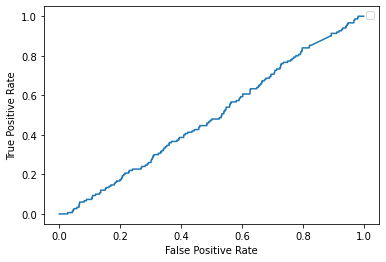

In [47]:
fpr, tpr, thresholds = roc_curve(y, pred)

plt.plot(fpr, tpr)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc=0)
plt.show()

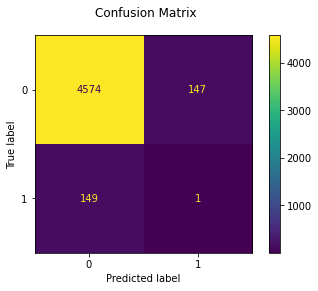

In [48]:
y_pred = (np.array(pred) >= 0.5).astype(int)
cm = confusion_matrix(y, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
disp.figure_.suptitle("Confusion Matrix")
plt.show()

#### Visualization (Heatmaps)

In [73]:
def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

def predict_on_slide(slide_path, mask_path):
  # Using 2 levels of resolution to predict and visualize results
  name = slide_path.split("/")[-1].split(".")[0]
  slide = open_slide(slide_path)
  mask = open_slide(mask_path)
  level_1 = 2
  level_2 = 3
  width_l1, height_l1 = slide.level_dimensions[level_1]
  downsampling_l1 = int(slide.level_downsamples[level_1])
  width_l2, height_l2 = slide.level_dimensions[level_2]
  downsampling_l2 = int(slide.level_downsamples[level_2])
  size = 299
  step = 299
  width_7, height_7 = slide.level_dimensions[7]
  width, height = width_l1//step, height_l1//step
  disp_img = read_slide(slide, x=0, y=0, level=7, 
                        width= width_7, height=height_7)
  pred_mask = np.zeros((height, width))
  disp_mask = read_slide(mask, x=0, y=0, level=7, 
                        width= width_7, height=height_7)[:,:,0]

  for x, m in zip(range(0, width_l1, step), range(height)):
    for y, n in zip(range(0, height_l1, step), range(width)):
      image_l1 = read_slide(slide, x= x * downsampling_l1, y= y * downsampling_l1, 
                         level=2, width=size, height=size)
      if tissue_above_threshold(image_l1):
        x_center, y_center = get_center_coordinates(x, y, size)
        x_center, y_center = convert_scale(x_center, y_center, downsampling_l1, downsampling_l2)
        x_new, y_new = get_top_left_coordinates(x_center, y_center, size)
        image_l2 = read_slide(slide, x= x_new * downsampling_l2, y= y_new * downsampling_l2, 
                         level=5, width=size, height=size)
        image_l1 = tf.expand_dims(image_l1/255., axis=0)
        image_l2 = tf.expand_dims(image_l2/255, axis=0)
        
        pred = model.predict(x= (image_l1, image_l2), verbose=0)
        if pred >= 0.5:
          pred_mask[m, n] = pred

  return disp_img, disp_mask, pred_mask 
 

In [74]:
s1, m1 = os.path.join(slides_path, slides_test[0]), os.path.join(masks_path, 
                                                                 masks_test[0])
disp_img, disp_mask, pred_mask  = predict_on_slide(s1, m1)

Text(0.5, 1.0, 'Predicted Mask')

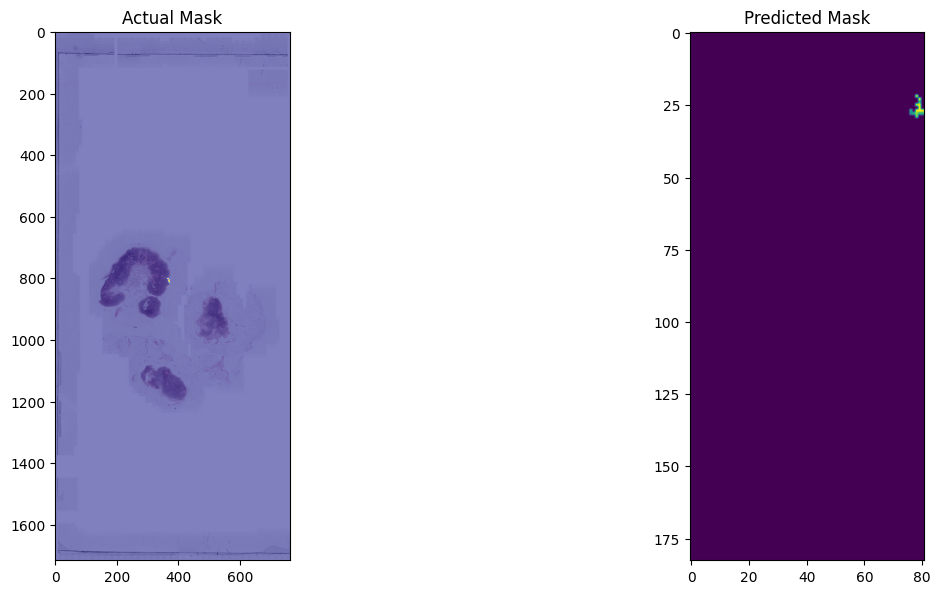

In [75]:
plt.figure(figsize=(15, 7), dpi=100)
plt.subplot(1, 2, 1)
plt.imshow(disp_img)
plt.imshow(disp_mask, cmap='jet', alpha=0.5) # Red regions contains cancer.
plt.title("Actual Mask")

plt.subplot(1, 2, 2)
plt.imshow(pred_mask) # Red regions contains cancer.
plt.title("Predicted Mask")

In [60]:
s2, m2 = os.path.join(slides_path, slides_test[1]), os.path.join(masks_path, 
                                                                 masks_test[1])
disp_img_2, disp_mask_2, pred_mask_2  = predict_on_slide(s2, m2)

Text(0.5, 1.0, 'Predicted Mask')

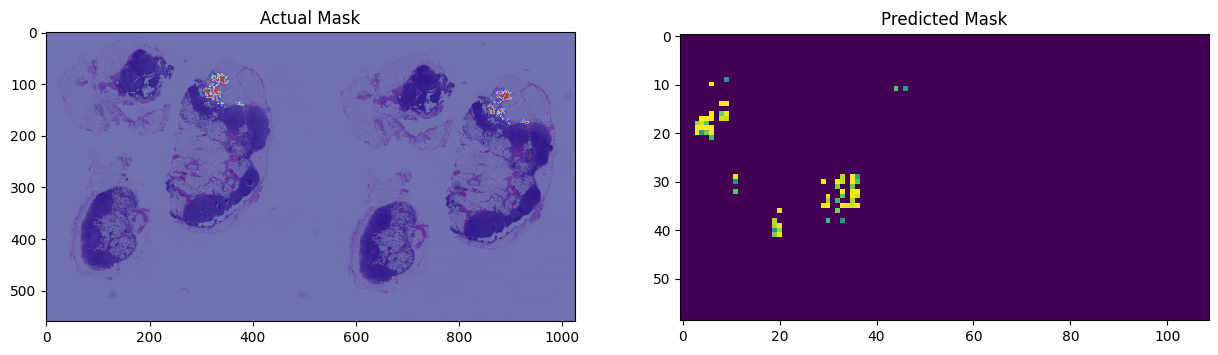

In [61]:
plt.figure(figsize=(15, 7), dpi=100)
plt.subplot(1, 2, 1)
plt.imshow(disp_img_2)
plt.imshow(disp_mask_2, cmap='jet', alpha=0.5) # Red regions contains cancer.
plt.title("Actual Mask")

plt.subplot(1, 2, 2)
plt.imshow(pred_mask_2) # Red regions contains cancer.
plt.title("Predicted Mask")

In [58]:
s3, m3 = os.path.join(slides_path, slides_test[2]), os.path.join(masks_path, 
                                                                 masks_test[2])
disp_img_3, disp_mask_3, pred_mask_3  = predict_on_slide(s3, m3)

Text(0.5, 1.0, 'Predicted Mask')

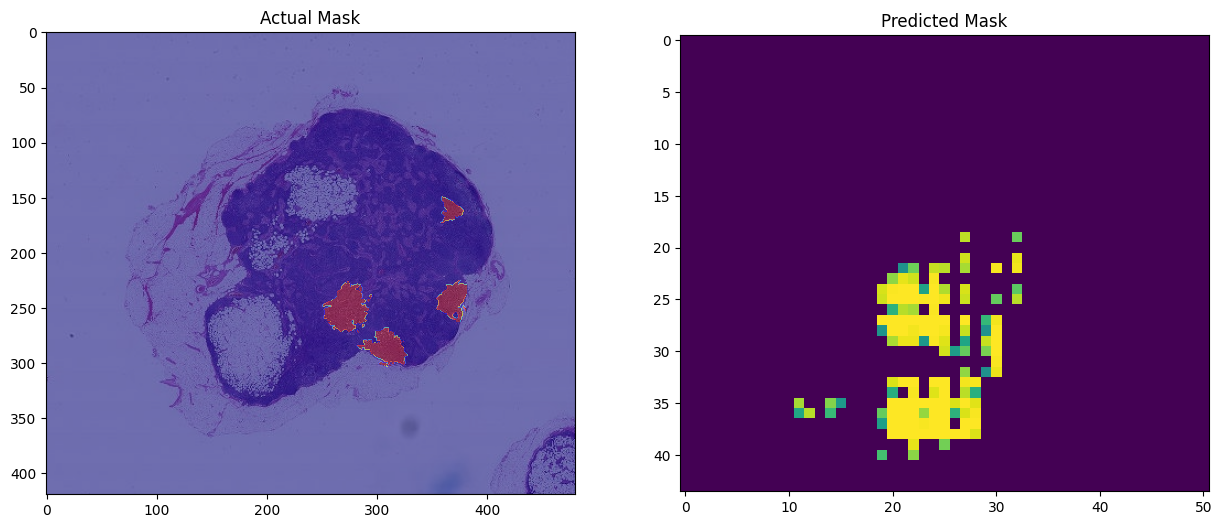

In [59]:
plt.figure(figsize=(15, 7), dpi=100)
plt.subplot(1, 2, 1)
plt.imshow(disp_img_3)
plt.imshow(disp_mask_3, cmap='jet', alpha=0.5) # Red regions contains cancer.
plt.title("Actual Mask")

plt.subplot(1, 2, 2)
plt.imshow(pred_mask_3) # Red regions contains cancer.
plt.title("Predicted Mask")

In [76]:
s4, m4 = os.path.join(slides_path, slides_test[3]), os.path.join(masks_path, 
                                                                 masks_test[3])
disp_img_4, disp_mask_4, pred_mask_4  = predict_on_slide(s4, m4)

Text(0.5, 1.0, 'Predicted Mask')

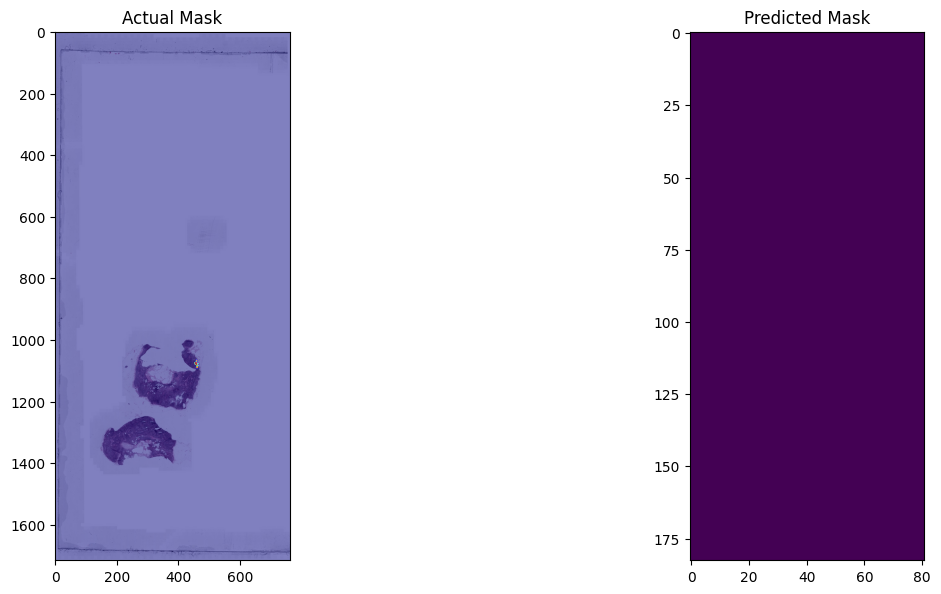

In [77]:
plt.figure(figsize=(15, 7), dpi=100)
plt.subplot(1, 2, 1)
plt.imshow(disp_img_4)
plt.imshow(disp_mask_4, cmap='jet', alpha=0.5) # Red regions contains cancer.
plt.title("Actual Mask")

plt.subplot(1, 2, 2)
plt.imshow(pred_mask_4) # Red regions contains cancer.
plt.title("Predicted Mask")